# Mineral Resource estimation with PyGSLIB (Quick Demo)

This demo is using the geology dream dataset

Here you will learn how to: 
 - import drillhole tables
 - create drillholes
 - tag drillholes with domain
 - composite
 - create a block model
 - do statistical analysis (no variography)
 - interpolate grade and validate interpolations
 - Report resources
 
 <img src = fig1.JPG>
 

### Import pygslib and other required python libraries


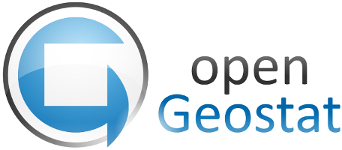

In [1]:
# Import libraries 
import pandas as pd 
import pygslib
import numpy as np
import matplotlib.pyplot as plt    
%matplotlib inline 

### Import drillhole tables

In [2]:
# Import drillhole data into pandas dataframes
collar = pd.read_csv('geology_dream_data/collar.csv')
survey = pd.read_csv('geology_dream_data/survey.csv')
assay  = pd.read_csv('geology_dream_data/assay.csv')

### Create a drillholes

In [3]:
# create drillhole object
mydholes = pygslib.drillhole.Drillhole(collar, survey)   
# add intervall table
mydholes.addtable(table = assay, table_name = 'assay')  

In [4]:
# validate
mydholes.validate()
mydholes.validate_table('assay')

In [5]:
# desurvey
mydholes.desurvey('assay', endpoints=True)

In [6]:
# export drillhole as vtk file
mydholes.intervals2vtk(table_name= 'assay', filename= 'assay')

C:\Users\AMartinez\AppData\Local\Continuum\miniconda3\lib\site-packages\vtk\util\numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


### Tag drillholes with domain (wireframe solid)

In [7]:
# import wireframe
dom1_poly= pygslib.vtktools.loadVTP('geology_dream_data/dom1.vtp')

# create array to tag samples in domain1
inside1=pygslib.vtktools.pointinsolid(dom1_poly, 
                       x=mydholes.table['assay']['xm'].values, 
                       y=mydholes.table['assay']['ym'].values, 
                       z=mydholes.table['assay']['zm'].values)

# create a new domain field 
mydholes.table['assay']['Domain1']=inside1.astype(int)

# export drillhole as vtk file
mydholes.intervals2vtk(table_name= 'assay', filename= 'assay')

###  Composite

In [8]:
# extract samples from domain 1 and add it as a new table
mydholes.addtable(mydholes.table['assay'].loc[mydholes.table['assay']['Domain1']==1, :], 'assay_d1', overwrite = True)

# composite only using samples in Dom1
mydholes.downh_composite('assay_d1','Au', 'cmp', cint = 1, overwrite = True)

# need to desurvey cmp
mydholes.desurvey('cmp')

# export drillholes as a vtk file
mydholes.intervals2vtk(table_name= 'cmp', filename= 'cmp')

###  Create a block model

In [9]:
#create an empty model
mymodel = pygslib.blockmodel.Blockmodel(xorg = 0,
                                        yorg = 0,
                                        zorg = 0,
                                        dx = 5,
                                        dy = 5,
                                        dz = 5,
                                        nx = 36,
                                        ny = 40,
                                        nz = 30)

#generate blocks and calculate percent in domain 1 (resolution 1/4)
_ = mymodel.fillwireframe(dom1_poly)

# remove blocks out of domain 1
mymodel.set_blocks (mymodel.bmtable[mymodel.bmtable['__in']>0])

# and save the model as vtkunestructured grid
mymodel.blocks2vtkUnstructuredGrid('bmodel') # this will have extension vtu

### Statistical analysis (no variography)

#### Declustering

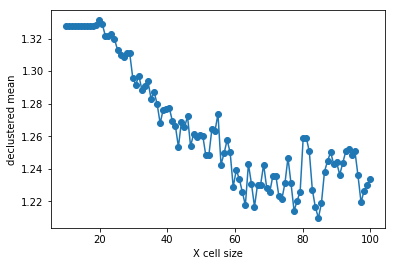

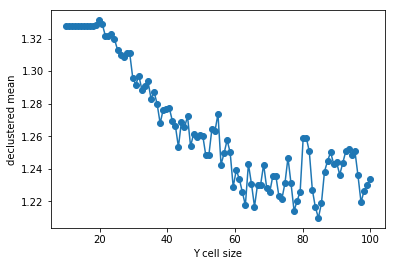

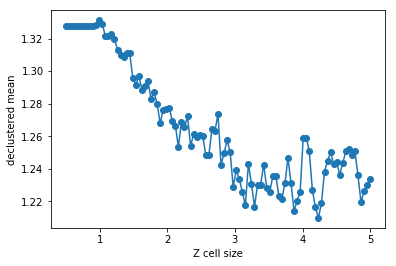

In [10]:
#declustering parameters 
parameters_declus = { 
        'x'      :  mydholes.table['cmp'].loc[:, 'xm'], 
        'y'      :  mydholes.table['cmp'].loc[:, 'ym'],  
        'z'      :  mydholes.table['cmp'].loc[:, 'zm'], 
        'vr'     :  mydholes.table['cmp'].loc[:, 'Au'],   
        'anisy'  :  1.,       
        'anisz'  :  .05,              
        'minmax' :  0,                 
        'ncell'  :  100,                  
        'cmin'   :  10., 
        'cmax'   :  100.,                 
        'noff'   :  8,                    
        'maxcel' :  -1}               

# declustering 
wtopt,vrop,wtmin,wtmax,error, \
xinc,yinc,zinc,rxcs,rycs,rzcs,rvrcr = pygslib.gslib.declus(parameters_declus)

# plotting declustering optimization results
plt.plot (rxcs, rvrcr, '-o')
plt.xlabel('X cell size')
plt.ylabel('declustered mean')
plt.show()
plt.plot (rycs, rvrcr, '-o')
plt.xlabel('Y cell size')
plt.ylabel('declustered mean')
plt.show()
plt.plot (rzcs, rvrcr, '-o')
plt.xlabel('Z cell size')
plt.ylabel('declustered mean')
plt.show()

Now we fix the cell size to 60 x 60 x 3 

In [11]:
#declustering parameters 
parameters_declus['ncell'] = 1
parameters_declus['cmin'] = 60.
parameters_declus['cmax'] = 60.
   
# declustering 
wtopt,vrop,wtmin,wtmax,error, \
xinc,yinc,zinc,rxcs,rycs,rzcs,rvrcr = pygslib.gslib.declus(parameters_declus)

# Adding declustering weight to a drillhole interval table
mydholes.table['cmp']['declustwt'] = 1
mydholes.table['cmp'].loc[:, 'declustwt'] = wtopt

# calculating declustered mean
decl_mean = rvrcr[0]

print ('declustered mean:', decl_mean)

declustered mean: 1.2334635703750538


#### Variography

For now use this variogram model

In Pygslib: 
```
vario_model = {
            # Variogram parameters Pygslib
            # ----------
            'c0'         : 0.1,   
            'it'         : [1],    # 
            'cc'         : [.9],     
            'aa'         : [100],   
            'aa1'        : [100],  
            'aa2'        : [20],   
            'ang1'       : [0],   
            'ang2'       : [0],  
            'ang3'       : [-15]}  

```


In gslib: 

```
1    0.1                      -nst, nugget effect
1    0.9  0.0   0.0  -15.0     -it,cc,ang1,ang2,ang3
       100.0  100.0  20.0     -a_hmax, a_hmin, a_vert


nst and c0: the number of variogram structures and the nugget
it:  the type of structure
cc:  the c parameter "sill"
ang1,ang2,ang3: the angles defining the geometric anisotropy
aa: also aa_hmax, the maximum horizontal range
aa1: also aa_hmin, the minimum horizontal range
aa2: also aa_vert, the vertical range


it is 

1. Spherical (use actual range)
2. Exponential (use practical range)
3. Gaussian (use practical range)
4. Power law variogram
5. Cosine hole effect model


```

### Interpolation and validation

In [12]:
# create BHID of type integer, this is to be able to use drillhole id in Fortran!
mydholes.txt2intID('cmp')

In [13]:
# create parameter dictionary for estimation
kt3d_Parameters = {
            # Input Data (Only using intervals in the mineralized domain)
            # ----------
            'x' : mydholes.table["cmp"]['xm'].values, 
            'y' : mydholes.table["cmp"]['ym'].values,
            'z' : mydholes.table["cmp"]['zm'].values,
            'vr' : mydholes.table["cmp"]['Au'].values,
            'bhidint' : mydholes.table["cmp"]['BHIDint'].values, # an interger BHID
            # Output (Target) 
            # ----------
            'nx' : 100,  # these parameters are only used to define supperblock search
            'ny' : 100,  
            'nz' : 100, 
            'xmn' : 0,  
            'ymn' : 0,  
            'zmn' : 0,  
            'xsiz' : 5,  
            'ysiz' : 5,   
            'zsiz' : 5, 
            'nxdis' : 5,  
            'nydis' : 5,  
            'nzdis' : 3,  
            'outx' : mymodel.bmtable['XC'].values,  
            'outy' : mymodel.bmtable['YC'].values,
            'outz' : mymodel.bmtable['ZC'].values,
            # Search parameters 
            # ----------
            'radius'     : 60,   
            'radius1'    : 60,   
            'radius2'    : 8,   
            'sang1'      : 0,  
            'sang2'      : 0,   
            'sang3'      : -15,   
            'ndmax'      : 20,    
            'ndmin'      : 7,  
            'noct'       : 0,
            'nbhid'      : 5,   
            # Kriging parameters and options 
            # ----------
            'ktype'      : 1,   # 1 Ordinary kriging 
            'idbg'       : 0,   # 0 no debug 
            # Variogram parameters Pygslib
            # ----------
            'c0'         : 0.1,   
            'it'         : [1],    
            'cc'         : [.9],     
            'aa'         : [100],   
            'aa1'        : [100],  
            'aa2'        : [20],   
            'ang1'       : [0],   
            'ang2'       : [0],  
            'ang3'       : [-15]}   

In [14]:
# estimating in all blocks
estimate, debug, summary = pygslib.gslib.kt3d(kt3d_Parameters)

In [15]:
# adding the estimate into the model
mymodel.bmtable['Au_OK'] = estimate['outest']
mymodel.bmtable['Au_ID2'] = estimate['outidpower']
mymodel.bmtable['Au_NN'] = estimate['outnn']
mymodel.bmtable['Au_Lagrange'] = estimate['outlagrange']
mymodel.bmtable['Au_KVar']= estimate['outkvar']

In [16]:
# exporting block model to VTK (unstructured grid) 
mymodel.blocks2vtkUnstructuredGrid(path='bmodel.vtu')

### Validating results

Basic validations are:

 - visual validation
 - comparison of mean grades
 - swath plots 
 - global change of support (GCOS)


#### Visual validations 

Use Paraview

#### Mean comparison

In [17]:
print ("Mean in model OK   :",  mymodel.bmtable['Au_OK'].mean())
print ("Mean in model ID2   :",  mymodel.bmtable['Au_ID2'].mean())
print ("Mean in model NN   :",  mymodel.bmtable['Au_NN'].mean())
print ("Mean in data    :", mydholes.table["cmp"]['Au'].mean())
print ("Declustered mean:", decl_mean)

Mean in model OK   : 1.1652812957763672
Mean in model ID2   : 1.3255397081375122
Mean in model NN   : 1.130252480506897
Mean in data    : 1.327910876878377
Declustered mean: 1.2334635703750538


#### Swath plots


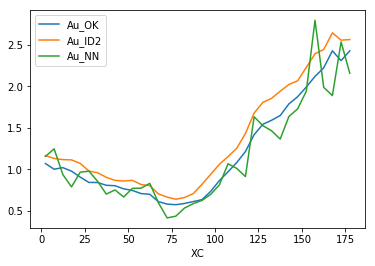

In [18]:
mymodel.bmtable.groupby('XC')[['Au_OK','Au_ID2','Au_NN']].mean().plot()

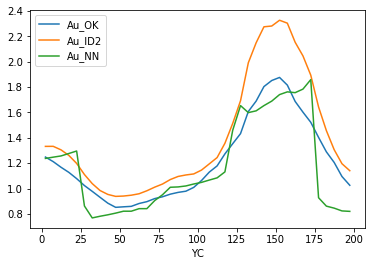

In [19]:
mymodel.bmtable.groupby('YC')[['Au_OK','Au_ID2','Au_NN']].mean().plot()

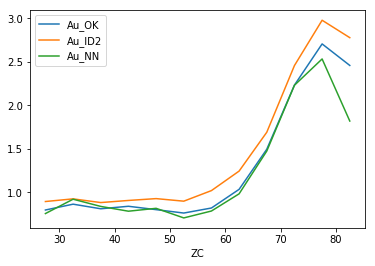

In [20]:
mymodel.bmtable.groupby('ZC')[['Au_OK','Au_ID2','Au_NN']].mean().plot()

#### Global change of support  

Raw Variance 2.1061216069329984
Variance from PCI 2.094884672460484
zamin 0.03685925411414369
zamax 9.442381351285942
yamin -2.475495099019804
yamax 2.7095419083816763
zpmin 0.03681988794743433
zpmax 9.55869048194472
ypmin -2.7615523104620925
ypmax 3.0176035207041405


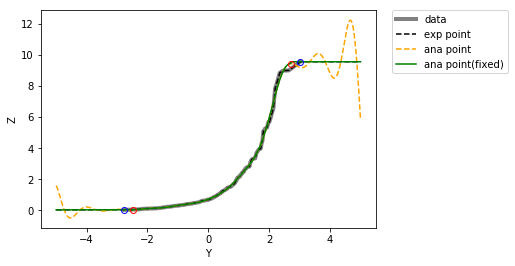

In [21]:
# fit anamorphosis by changing, zmax, zmin, and extrapolation function
PCI, H, raw, zana, gauss, z, P, raw_var, PCI_var, fig1 = pygslib.nonlinear.anamor(
                         z = mydholes.table["cmp"]['Au'], 
                         w = mydholes.table["cmp"]['declustwt'], 
                         zmin = mydholes.table["cmp"]['Au'].min(), 
                         zmax = mydholes.table["cmp"]['Au'].max(),
                         zpmin = None, zpmax = None,
                         ymin=-5, ymax=5,
                         ndisc = 5000,
                         ltail=1, utail=4, ltpar=1, utpar=1.5, K=40)

In [22]:
# calc block covariance
parameters_cov = {
           # Coordinates of the discretization points (using 500 points located at random in the block)
            'xdb'  :  np.random.rand(1000)*5, # array('f')
            'ydb'  :  np.random.rand(1000)*5, # array('f')
            'zdb'  :  np.random.rand(1000)*5, # array('f')
           # Variogram model
            'c0'         : 0.1,   
            'it'         : [1],    
            'cc'         : [.9],     
            'aa'         : [100],   
            'aa1'        : [100],  
            'aa2'        : [20],   
            'ang1'       : [0],   
            'ang2'       : [0],  
            'ang3'       : [-15]} 


cbb = pygslib.gslib.block_covariance(parameters_cov)

# calculate the support correction coefficient r
r = pygslib.nonlinear.get_r(Var_Zv = cbb, PCI = PCI)

print ('cbb :', cbb)
print ('r   :', r)

cbb : 0.776299172422506
r   : 0.678879139828761


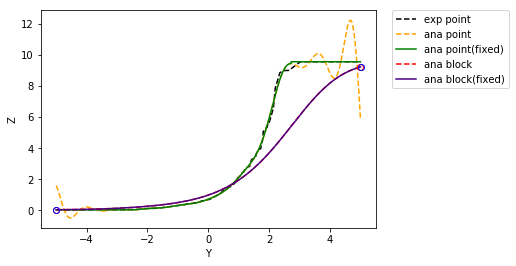

In [23]:
# fit block anamorphosis
ZV, PV, fig2 = pygslib.nonlinear.anamor_blk( PCI, H, r = r, gauss = gauss, Z = z,
                  ltail=1, utail=1, ltpar=1, utpar=1,
                  raw=raw, zana=zana)

In [24]:
# calculate grade tonnage courve

cutoff = np.arange(0, 3, 0.01)
tt = []
gg = []
label = []

# calculate GTC from gaussian in block support 
t,ga,gb = pygslib.nonlinear.gtcurve (cutoff = cutoff, z=ZV, p=PV, varred = 1, ivtyp = 0, zmin = 0, zmax = None,
             ltail = 1, ltpar = 1, middle = 1, mpar = 1, utail = 1, utpar = 1,maxdis = 1000)
tt.append(t)
gg.append(ga)
label.append('DGM with block support')

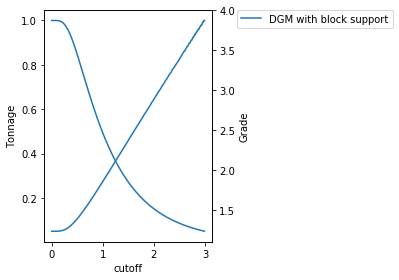

In [25]:
# see how it look with GCOS. This is also know as global estimation
fig = pygslib.nonlinear.plotgt(cutoff = cutoff, t = tt, g = gg, label = label)

In [26]:
# to compare global resources with the one estimated we calculate the CDF of the blocks

# cdf of kriging estimate
parameters_probplt = {
        'iwt'  : 0,                             #int, 1 use declustering weight
        'va'   : mymodel.bmtable['Au_OK'][mymodel.bmtable['Au_OK'].notnull()].values,             # array('d') with bounds (nd)
        'wt'   : np.ones(mymodel.bmtable['Au_OK'][mymodel.bmtable['Au_OK'].notnull()].shape[0])} # array('d') with bounds (nd), wight variable (obtained with declust?)


binval_ok,cl_ok,xpt025,xlqt,xmed,xuqt,xpt975,xmin,xmax, \
xcvr,xmen,xvar,error = pygslib.gslib.__plot.probplt(**parameters_probplt)

# cdf of id2
parameters_probplt = {
        'iwt'  : 0,                             #int, 1 use declustering weight
        'va'   : mymodel.bmtable['Au_ID2'][mymodel.bmtable['Au_OK'].notnull()].values,             # array('d') with bounds (nd)
        'wt'   : np.ones(mymodel.bmtable['Au_OK'][mymodel.bmtable['Au_OK'].notnull()].shape[0])} # array('d') with bounds (nd), wight variable (obtained with declust?)

binval_id2,cl_id2,xpt025,xlqt,xmed,xuqt,xpt975,xmin,xmax, \
xcvr,xmen,xvar,error = pygslib.gslib.__plot.probplt(**parameters_probplt)

In [27]:
# calculate GTC ok 
t,ga,gb = pygslib.nonlinear.gtcurve (cutoff = cutoff, z=cl_ok, p=binval_ok, varred = 1, ivtyp = 2, zmin = 0, zmax = None,
             ltail = 1, ltpar = 1, middle = 1, mpar = 1, utail = 1, utpar = 1,maxdis = 1000)
tt.append(t)
gg.append(ga)
label.append('Ordinary Kriging')

# calculate GTC in block support
t,ga,gb = pygslib.nonlinear.gtcurve (cutoff = cutoff, z=cl_id2, p=binval_id2, varred = 1, ivtyp = 2, zmin = 0, zmax = None,
             ltail = 1, ltpar = 1, middle = 1, mpar = 1, utail = 1, utpar = 1,maxdis = 1000)
tt.append(t)
gg.append(ga)
label.append('Inverse of the Distance 2)')

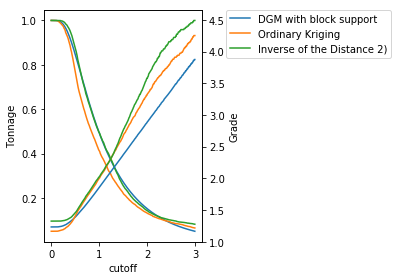

In [28]:
fig = pygslib.nonlinear.plotgt(cutoff = cutoff, t = tt, g = gg, label = label)

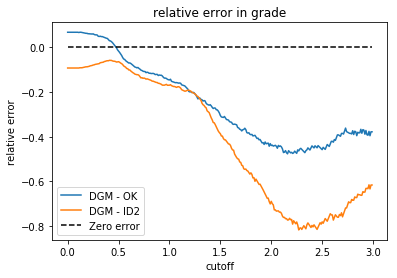

In [29]:
# we can plot diferences (relative error in grade)
plt.plot (cutoff, gg[0]-gg[1], label = 'DGM - OK')
plt.plot (cutoff, gg[0]-gg[2], label = 'DGM - ID2')
plt.plot (cutoff, np.zeros(cutoff.shape[0]),'--k', label = 'Zero error')
plt.title('relative error in grade')
plt.xlabel ('cutoff')
plt.ylabel ('relative error')
plt.legend()

Text(0.5,1,'relative error in tonnage')

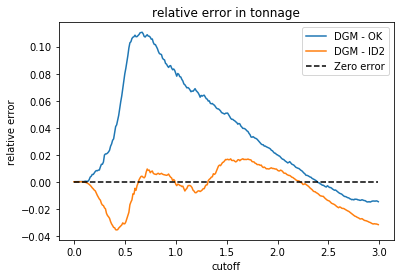

In [30]:
# we can plot diferences (relative error in tonnage)
plt.plot (cutoff, tt[0]-tt[1], label = 'DGM - OK')
plt.plot (cutoff, tt[0]-tt[2], label = 'DGM - ID2')
plt.plot (cutoff, np.zeros(cutoff.shape[0]),'--k', label = 'Zero error')
plt.legend()
plt.xlabel ('cutoff')
plt.ylabel ('relative error')
plt.title('relative error in tonnage')